In [1]:

import torch
import torch.nn.functional as F  # This is the correct import
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from clip_classifier import CustomAttributeClassifier
from models import Encoder, Decoder, CVAE
from dataset import CelebaDataset, transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from plots import save_training_visualizations


In [13]:
from dotenv import load_dotenv


def generate_clip_labels(user_attributes, img_dir, max_images=100):
    """
    Generate labels for images using CLIP classifier.
    
    Args:
        user_attributes: Dictionary of attribute names and their possible values
        img_dir: Directory containing the images
        max_images: Maximum number of images to process
    
    Returns:
        results_df: DataFrame containing image IDs and their attribute classifications
    """
    print("Step 1: Generating labels using CLIP...")
    
    # Initialize CLIP classifier
    # Load environment variables
    load_dotenv()
    
    # Get the API key
    api_key = os.getenv("OPENAI_API_KEY")
    
    # Create the classifier with explicit API key
    classifier = CustomAttributeClassifier(clip_model_name="ViT-B/16",openai_api_key=api_key)
        
    # Get list of all image files
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    # Take only first max_images
    selected_files = image_files[:max_images]
    print(f"\nProcessing {len(selected_files)} images out of {len(image_files)} total images")
    
    # Create a temporary directory with symlinks to selected images
    import tempfile
    import shutil
    
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create symlinks for selected images
        for img_file in selected_files:
            src = os.path.join(img_dir, img_file)
            dst = os.path.join(temp_dir, img_file)
            if os.path.exists(src):
                os.symlink(src, dst)
    
        # Classify only selected images
        results_df = classifier.classify_images(
            img_dir=temp_dir,
            attribute_values=user_attributes,
            batch_size=16
        )
    
    return results_df

In [14]:
def train_vae_model(results_df, user_attributes, img_dir, device="cuda", batch_size=32, num_epochs=1201, vis_dir=None):
    """
    Train the VAE model using pre-generated labels.
    
    Args:
        results_df: DataFrame containing image IDs and their attribute classifications
        user_attributes: Dictionary of attribute names and their possible values
        img_dir: Directory containing the images
        device: Device to run the model on
        batch_size: Batch size for training
        num_epochs: Number of epochs to train
        vis_dir: Directory to save visualizations
    
    Returns:
        vae: Trained VAE model
        loss_history: Dictionary containing training loss history
    """
    print("\nStep 2: Preparing dataset...")
    
    # Create attribute dimensions dictionary for decoder
    attribute_dims = {attr: len(values) for attr, values in user_attributes.items()}
    
    # Initialize dataset and dataloader
    dataset = CelebaDataset(
        df=results_df,
        img_dir=img_dir,
        transform=transform,
        attribute_names=list(user_attributes.keys())
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    
    print("\nStep 3: Initializing model...")
    
    # Initialize VAE with dynamic attributes
    vae = CVAE(Encoder, Decoder, attribute_dims)
    vae.to(device)
    
    optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    
    print("\nStep 4: Starting training...")
    
    # Training loop
    loss_history = {
        'total': [],
        'reconstruction': [],
        'kl': [],
    }
    
    for epoch in range(num_epochs):
        vae.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        
        pbar = tqdm(total=len(dataloader), desc=f'Epoch {epoch}', position=0, leave=True)
        
        for batch_idx, (images, attrs) in enumerate(dataloader):
            images = images.to(device)
            attrs = attrs.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_images, mu, logvar = vae(images, attrs)
            
            # Compute losses
            recon_loss = torch.nn.functional.binary_cross_entropy(recon_images, images, reduction='sum')
            recon_loss = recon_loss / (images.size(0) * 3 * 64 * 64)
            
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            KLD = KLD / (images.size(0) * 3 * 64 * 64)
            
            total_loss = recon_loss + KLD
            
            total_loss.backward()
            optimizer.step()
            
            # Accumulate losses
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += KLD.item()
            
            pbar.update(1)
            
            # Visualize first batch
            if batch_idx == 0 and epoch % 10 == 0:
                save_training_visualizations(
                    vae, clip_consistency, (images[:5], attrs[:5]), 
                    epoch, vis_dir
                )
        
        pbar.close()
        
        # Rest of the training loop code (loss calculations, checkpoints, etc.)
        # [Previous code remains the same]
        
    return vae, loss_history

In [24]:

# User-defined attributes
user_attributes = {
    "ethnicity": ["African", "Asian", "European"],
    "facial_expression": [
     "happy", "sad", "angry"
]
}

# Image directory
img_dir = "/home/omrid/Desktop/jungo /projectCLIPvae/celeba_dataset/img_align_celeba/img_align_celeba"
vis_dir = os.path.join('training_outputs', 'visualizations')
os.makedirs(vis_dir, exist_ok=True)

# Step 1: Generate labels using CLIP
results_df = generate_clip_labels(
    user_attributes=user_attributes,
    img_dir=img_dir,
    max_images=50000
)



Step 1: Generating labels using CLIP...
Initializing CLIP model on cuda
OpenAI API key found!

Initializing Template Generator...
API Key provided: Yes
Successfully initialized ChatOpenAI

Processing 50000 images out of 202599 total images
Generating templates...

Attempting to generate templates using GPT...

Generating templates for attributes:
ethnicity: African, Asian, European
facial_expression: happy, sad, angry

Sending request to GPT...

Received response from GPT. First 200 characters:
{
    "ethnicity": {
        "African": [
            "a photograph of a person with African features",
            "an African person",
            "a face with African characteristics",
            ...

Successfully parsed JSON response

Template structure:

ethnicity:
  African: 5 templates
  Asian: 5 templates
  European: 5 templates

facial_expression:
  happy: 5 templates
  sad: 5 templates
  angry: 5 templates
Successfully generated templates using GPT!

Current Templates:

ETHNICITY:
---

Classifying images: 100%|██████████| 3125/3125 [04:40<00:00, 11.14it/s]



Processed 50000 images successfully

Attribute distribution:

Ethnicity Distribution:
------------------------------
African                  :  4,886 (   9.8%)
Asian                    :  8,596 (  17.2%)
European                 : 36,518 (  73.0%)

Facial_expression Distribution:
------------------------------
happy                    : 25,405 (  50.8%)
sad                      : 13,729 (  27.5%)
angry                    : 10,866 (  21.7%)


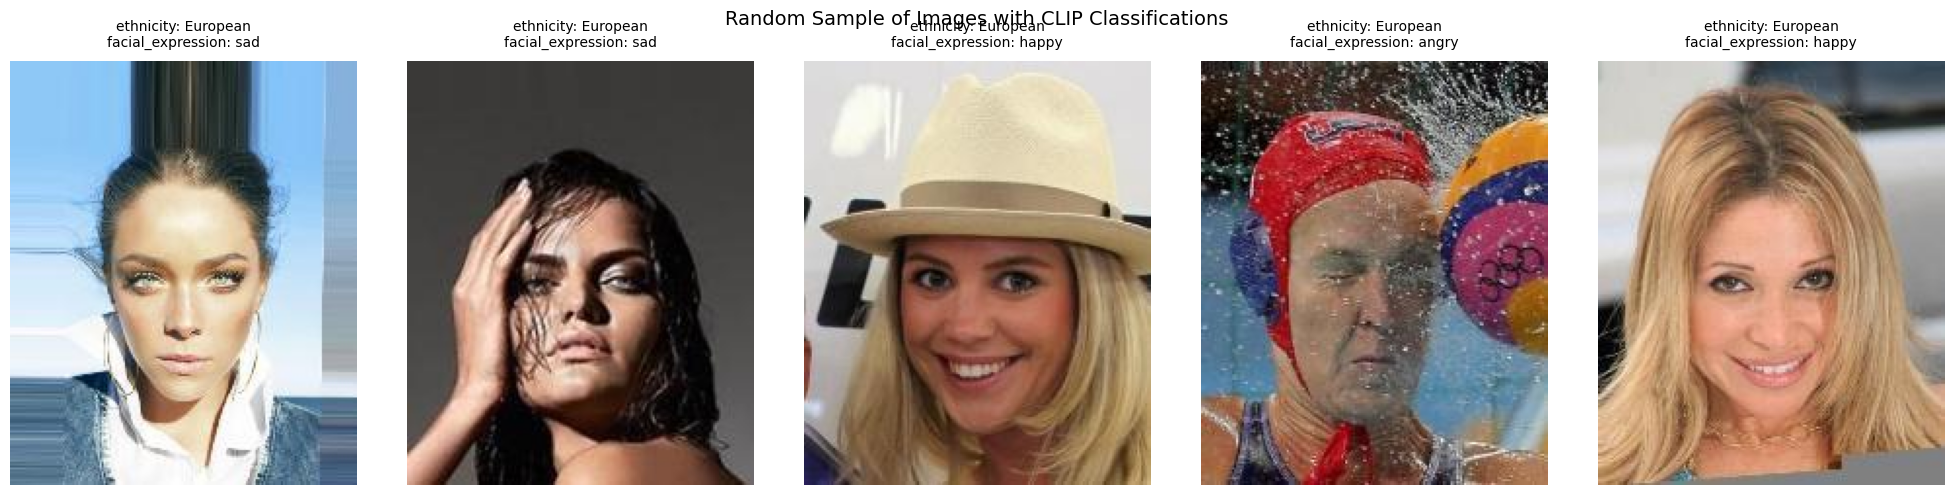


Detailed Classification Results:

Image: 123908.jpg
ethnicity: European
facial_expression: sad

Image: 057857.jpg
ethnicity: European
facial_expression: sad

Image: 108757.jpg
ethnicity: European
facial_expression: happy

Image: 048399.jpg
ethnicity: European
facial_expression: angry

Image: 071299.jpg
ethnicity: European
facial_expression: happy


In [25]:
# Import required libraries if not already imported
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Randomly sample 5 images from the results
sample_indices = np.random.choice(len(results_df), size=5, replace=False)
sample_rows = results_df.iloc[sample_indices]

# Create a figure to display images and their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Random Sample of Images with CLIP Classifications', fontsize=14)

# For each sampled image
for idx, (ax, (_, row)) in enumerate(zip(axes, sample_rows.iterrows())):
    # Load and display the image
    img_path = os.path.join(img_dir, row['image_id'])
    img = Image.open(img_path).convert('RGB')
    ax.imshow(img)
    ax.axis('off')
    
    # Create label text showing the classifications
    label_text = []
    for attr_name in user_attributes.keys():
        value = user_attributes[attr_name][int(row[attr_name])]
        label_text.append(f"{attr_name}: {value}")
    
    # Add the labels below the image
    ax.set_title('\n'.join(label_text), fontsize=10, pad=10)

plt.tight_layout()
plt.show()

# Print the full details for verification
print("\nDetailed Classification Results:")
for _, row in sample_rows.iterrows():
    print("\nImage:", row['image_id'])
    for attr_name in user_attributes.keys():
        value = user_attributes[attr_name][int(row[attr_name])]
        print(f"{attr_name}: {value}")

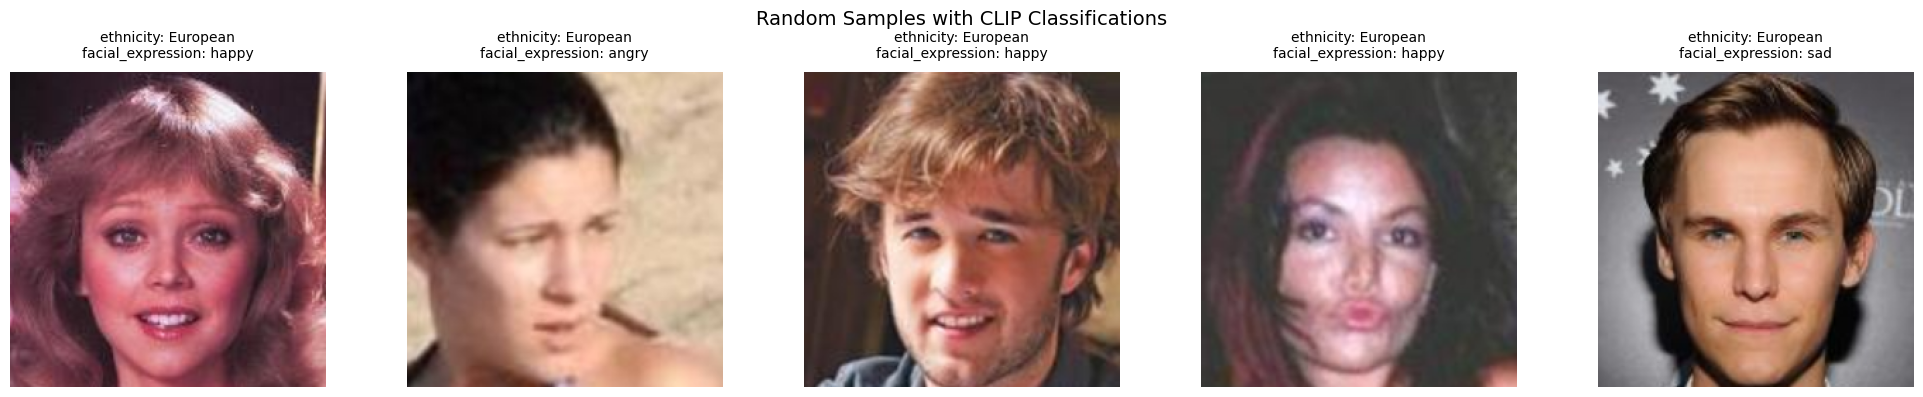

/tmp/ipykernel_1169409/3820415649.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


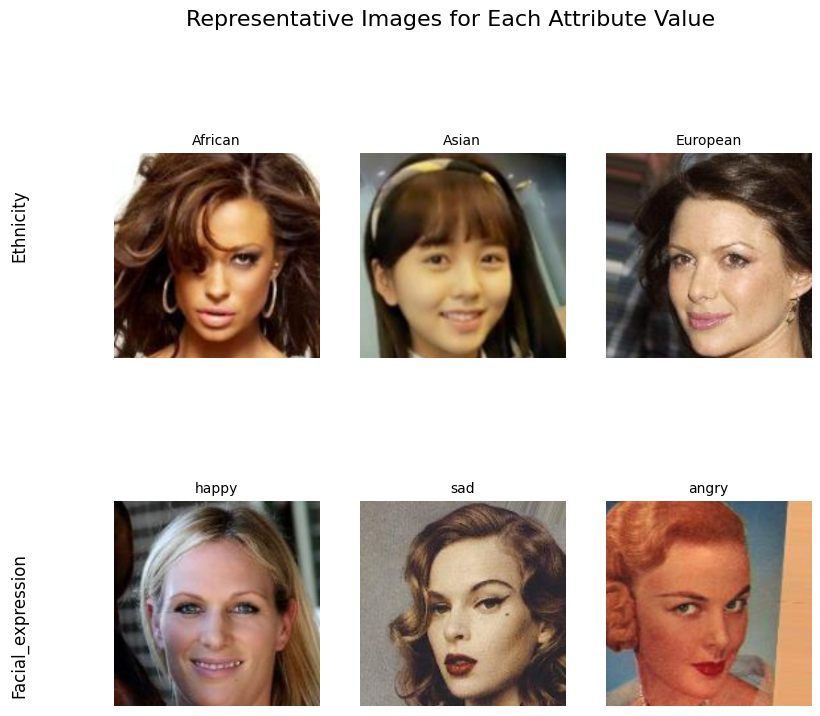


Attribute Value Distribution:

Ethnicity:
African        :  4886 images (  9.8%)
Asian          :  8596 images ( 17.2%)
European       : 36518 images ( 73.0%)

Facial_expression:
happy          : 25405 images ( 50.8%)
sad            : 13729 images ( 27.5%)
angry          : 10866 images ( 21.7%)


In [38]:
def create_attribute_visualization(results_df, user_attributes, img_dir):
    """
    Creates dynamic visualizations of CLIP classifications that adapt to any number of attributes and values.
    
    Args:
        results_df: DataFrame containing classification results
        user_attributes: Dictionary of attributes and their possible values
        img_dir: Directory containing the images
    """
    # Set up image preprocessing that maintains proper color representation
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    
    # First show random samples with all attributes
    show_random_samples(results_df, user_attributes, img_dir, preprocess)
    
    # Calculate layout dimensions
    n_attributes = len(user_attributes)
    max_values = max(len(values) for values in user_attributes.values())
    
    # Calculate figure size dynamically
    # Base width per image is 3 inches, height per row is 4 inches
    fig_width = min(20, 3 * max_values)  # Cap width at 20 inches
    fig_height = 4 * n_attributes
    
    # Create figure with dynamic subplot layout
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.suptitle('Representative Images for Each Attribute Value', fontsize=16, y=1.02)
    
    # Create a grid layout
    grid = plt.GridSpec(n_attributes, max_values, hspace=0.3, wspace=0.2)
    
    # Process each attribute
    for attr_idx, (attr_name, values) in enumerate(user_attributes.items()):
        # Add attribute name as a side label
        plt.figtext(0.01, 1 - (attr_idx + 0.5) / n_attributes, 
                   attr_name.capitalize(),
                   rotation=90, fontsize=12, va='center')
        
        # Create subplots for each value of this attribute
        for val_idx, value in enumerate(values):
            # Create subplot
            ax = fig.add_subplot(grid[attr_idx, val_idx])
            
            # Find matching images for this attribute value
            matching_images = results_df[results_df[attr_name] == val_idx]
            
            if len(matching_images) > 0:
                # Sample images and try to find a good representative
                samples = matching_images.sample(min(20, len(matching_images)))
                found_valid_image = False
                
                for _, sample in samples.iterrows():
                    try:
                        # Load and process image
                        img_path = os.path.join(img_dir, sample['image_id'])
                        img = Image.open(img_path).convert('RGB')
                        img_tensor = preprocess(img)
                        img_display = img_tensor.numpy().transpose(1, 2, 0)
                        
                        # Validate image quality
                        if 0.2 < img_display.mean() < 0.8:
                            ax.imshow(img_display)
                            ax.set_title(f'{value}', fontsize=10)
                            found_valid_image = True
                            break
                    except Exception as e:
                        continue
                
                if not found_valid_image:
                    ax.text(0.5, 0.5, 'No valid\nimage found', 
                          ha='center', va='center', fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No examples\nfound', 
                       ha='center', va='center', fontsize=8)
            
            ax.axis('off')
            
            # If this is the last value for this attribute, hide remaining grid cells
            if val_idx == len(values) - 1:
                for empty_idx in range(val_idx + 1, max_values):
                    empty_ax = fig.add_subplot(grid[attr_idx, empty_idx])
                    empty_ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print distribution statistics
    print("\nAttribute Value Distribution:")
    print("=" * 50)
    for attr_name, values in user_attributes.items():
        print(f"\n{attr_name.capitalize()}:")
        for val_idx, value in enumerate(values):
            count = len(results_df[results_df[attr_name] == val_idx])
            percentage = (count / len(results_df)) * 100
            print(f"{value:15s}: {count:5d} images ({percentage:5.1f}%)")


def show_random_samples(results_df, user_attributes, img_dir, preprocess):
    """
    Shows random samples with their classifications, adapting to the number of attributes.
    
    Args:
        results_df: DataFrame containing classification results
        user_attributes: Dictionary of attributes and their possible values
        img_dir: Directory containing the images
        preprocess: Transform pipeline for the images
    """
    # Determine number of samples based on figure width
    n_samples = min(5, len(results_df))  # Cap at 5 samples
    
    # Calculate figure size based on number of attributes
    n_attrs = len(user_attributes)
    fig_height = max(4, 1 + 0.5 * n_attrs)  # Base height plus space for labels
    
    fig, axes = plt.subplots(1, n_samples, figsize=(4*n_samples, fig_height))
    fig.suptitle('Random Samples with CLIP Classifications', fontsize=14)
    
    # Handle case where n_samples = 1
    if n_samples == 1:
        axes = [axes]
    
    samples = results_df.sample(n_samples)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        try:
            # Load and process image
            img_path = os.path.join(img_dir, row['image_id'])
            img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(img)
            img_display = img_tensor.numpy().transpose(1, 2, 0)
            
            axes[idx].imshow(img_display)
            axes[idx].axis('off')
            
            # Format labels with dynamic spacing
            labels = []
            for attr_name in user_attributes.keys():
                value = user_attributes[attr_name][int(row[attr_name])]
                labels.append(f"{attr_name}: {value}")
            
            # Adjust title position based on number of attributes
            axes[idx].set_title('\n'.join(labels), fontsize=10, pad=10)
            
        except Exception as e:
            print(f"Error processing image {row['image_id']}: {e}")
            axes[idx].text(0.5, 0.5, 'Error loading\nimage', 
                         ha='center', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    
create_attribute_visualization(results_df, user_attributes, img_dir)

In [ ]:
# Step 2: Train the VAE using the generated labels
vae, history = train_vae_model(
    results_df=results_df,
    user_attributes=user_attributes,
    img_dir=img_dir,
    batch_size=256,
    num_epochs=1201,
    vis_dir=vis_dir
)

In [ ]:



from celeba_project import clip_consistency


def train_flexible_vae(user_attributes, img_dir, max_images=100, device="cuda", batch_size=32, num_epochs=1201,vis_dir=None):
    """
    End-to-end training pipeline for flexible attributes
    """
    
    print("Step 1: Generating labels using CLIP...")
    
    # Initialize CLIP classifier
    classifier = CustomAttributeClassifier()
    
    # Get list of all image files
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    # Take only first max_images
    selected_files = image_files[:max_images]
    print(f"\nProcessing {len(selected_files)} images out of {len(image_files)} total images")
    
    # Create a temporary directory with symlinks to selected images
    import tempfile
    import shutil
    
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create symlinks for selected images
        for img_file in selected_files:
            src = os.path.join(img_dir, img_file)
            dst = os.path.join(temp_dir, img_file)
            if os.path.exists(src):
                os.symlink(src, dst)
    
        # Classify only selected images
        results_df = classifier.classify_images(
            img_dir=temp_dir,
            attribute_values=user_attributes,
            batch_size=16
        )
    
    print("\nStep 2: Preparing dataset...")
    
    # Create attribute dimensions dictionary for decoder
    attribute_dims = {attr: len(values) for attr, values in user_attributes.items()}
    
    # Initialize dataset and dataloader
    dataset = CelebaDataset(
        df=results_df,
        img_dir=img_dir,
        transform=transform,
        attribute_names=list(user_attributes.keys())
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    
    print("\nStep 3: Initializing model...")
    
    # Initialize VAE with dynamic attributes
    vae = CVAE(Encoder, Decoder, attribute_dims)
    vae.to(device)
    
    optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    
    print("\nStep 4: Starting training...")
    
    # Training loop
    loss_history = {
        'total': [],
        'reconstruction': [],
        'kl': [],
    }
    
    for epoch in range(num_epochs):
        vae.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        
        pbar = tqdm(total=len(dataloader), desc=f'Epoch {epoch}', position=0, leave=True)
        
        for batch_idx, (images, attrs) in enumerate(dataloader):
            images = images.to(device)
            attrs = attrs.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_images, mu, logvar = vae(images, attrs)
            
            # Compute losses
            recon_loss = torch.nn.functional.binary_cross_entropy(recon_images, images, reduction='sum')
            recon_loss = recon_loss / (images.size(0) * 3 * 64 * 64)
            
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            KLD = KLD / (images.size(0) * 3 * 64 * 64)
            
            total_loss = recon_loss + KLD
            
            total_loss.backward()
            optimizer.step()
            
            # Accumulate losses
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += KLD.item()
            
            pbar.update(1)
            
            # Visualize first batch
            if batch_idx == 0 and epoch % 10 == 0:
                    save_training_visualizations(
        vae, clip_consistency, (images[:5], attrs[:5]), 
        epoch, vis_dir
    )
        


        pbar.close()
        
        # Calculate averages
        avg_total = epoch_total_loss / len(dataloader)
        avg_recon = epoch_recon_loss / len(dataloader)
        avg_kl = epoch_kl_loss / len(dataloader)
        
        # Store losses
        loss_history['total'].append(avg_total)
        loss_history['reconstruction'].append(avg_recon)
        loss_history['kl'].append(avg_kl)
        
        # Print progress
        if epoch % 10 == 0:
            print(f"\nEpoch {epoch} Summary:")
            print(f"Total Loss: {avg_total:.6f}")
            print(f"Reconstruction Loss: {avg_recon:.6f}")
            print(f"KL Loss: {avg_kl:.6f}")
            
            # Plot loss curves
            plot_loss_curves(loss_history)
        
        # Save checkpoint
        if epoch % 20 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': vae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total,
            }, f"vae_checkpoint_epoch_{epoch}.pt")
    
    return vae, loss_history

def plot_samples(original_images, reconstructed_images, attrs, user_attributes, epoch):
    """Plot original and reconstructed images with their attributes"""
    fig, axes = plt.subplots(len(original_images), 2, figsize=(10, 3*len(original_images)))
    fig.suptitle(f'Original vs Reconstructed Images - Epoch {epoch}')
    
    for idx, (orig, recon, attr) in enumerate(zip(original_images, reconstructed_images, attrs)):
        # Display images
        axes[idx, 0].imshow(orig.cpu().permute(1, 2, 0).detach().numpy())
        axes[idx, 0].set_title('Original')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(recon.cpu().permute(1, 2, 0).detach().numpy())
        axes[idx, 1].set_title('Reconstructed')
        axes[idx, 1].axis('off')
        
        # Add attribute information
        attr_text = []
        for i, (attr_name, values) in enumerate(user_attributes.items()):
            value = values[int(attr[i].item())]
            attr_text.append(f"{attr_name}: {value}")
        
        plt.figtext(0.5, 0.98 - (idx * 0.2), ' | '.join(attr_text),
                   ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'reconstructions_epoch_{epoch}.png')
    plt.close()

def plot_loss_curves(loss_history):
    """Plot training progress"""
    plt.figure(figsize=(10, 5))
    for key, values in loss_history.items():
        plt.plot(values, label=key)
    plt.title('Training Losses Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_progress.png')
    plt.close()

# Example usage:
if __name__ == "__main__":
    # User-defined attributes
    user_attributes = {
        "ethnicity": ["African", "Asian", "European"],
        "age": ["baby", "middle aged", "elderly"]
    }
    
    # Image directory
    img_dir = "/home/omrid/Desktop/jungo /projectCLIPvae/celeba_dataset/img_align_celeba/img_align_celeba"
    vis_dir = os.path.join('training_outputs', 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Train the model with only 100 images
    vae, history = train_flexible_vae(
        user_attributes=user_attributes,
        img_dir=img_dir,
        max_images=50000,  # Limit to 100 images
        batch_size=256,   # Smaller batch size for small dataset
        num_epochs=1201,
        vis_dir=vis_dir
    )